In [1]:
import os
import argparse
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, mannwhitneyu
import sys
sys.path.append('/net/bgm/sherwood/NGS_analysis_proj/script/')
from access_util import *
from plotnine import *
import logging
logger = logging.getLogger()

2024-11-07 22:51:44.741498: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 22:51:44.751581: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 22:51:44.792603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 22:51:44.872678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 22:51:44.891533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 22:51:48.237665: W tensorflow/compiler/tf2tensorrt/utils/p

### comapare spearman correaltion between old data and new data

In [14]:
df_spearman_corr_old = pd.read_csv('/net/bgm/sherwood/factorbook_data/UltimaGen/evaluation_3stateModel/HepG2_100/summary/spearman_corr.csv')
df_spearman_corr = pd.read_csv('/net/bgm/sherwood/factorbook_data/UltimaGen/evaluation_3stateModel_v2/HepG2_100/summary/spearman_corr.csv')

df_spearman_corr_bound_old = df_spearman_corr_old.loc[df_spearman_corr_old['read_type'] == 'bound', ['cell_type', 'TF_name', 'motif_str', 'rho']].copy()
df_spearman_corr_bound_old.rename(columns={'rho': 'old model read fraction'}, inplace=True)

df_spearman_corr_bound = df_spearman_corr.loc[df_spearman_corr['read_type'] == 'bound'].copy()
df_spearman_corr_bound_wide = df_spearman_corr_bound.pivot(index=['cell_type', 'TF_name', 'motif_str'], columns='read_frac_type', values='rho').reset_index()
df_spearman_corr_bound_wide.rename(columns={'defined': 'new direct labeling', 'predicted': 'new model read fraction', 'predicted_prob': 'new model probability'}, inplace=True)

df_spearman_corr_bound_combined_wide = pd.merge(df_spearman_corr_bound_wide, df_spearman_corr_bound_old, on=['cell_type', 'TF_name', 'motif_str'], how='left')
df_spearman_corr_bound_combined = df_spearman_corr_bound_combined_wide.melt(id_vars=['cell_type', 'TF_name', 'motif_str'], var_name='read_frac_type', value_name='rho')
df_spearman_corr_bound_combined['read_frac_type'] = pd.Categorical(df_spearman_corr_bound_combined['read_frac_type'], categories=['old model read fraction', 'new direct labeling', 'new model read fraction', 'new model probability'], ordered=True)
df_spearman_corr_bound_combined

,cell_type,TF_name,motif_str,read_frac_type,rho
0,HepG2,AHR,ENCSR412ZDC_GCTGTCCRYGGTGCTGAA,new direct labeling,0.250432
1,HepG2,ATF1,ENCSR253OON_RTGACGTMANN,new direct labeling,0.353046
2,HepG2,ATF2,ENCSR047BUZ_DDNGATGACGTCAT,new direct labeling,0.268300
3,HepG2,ATF3,ENCSR000BKE_GGTSACGTGRB,new direct labeling,0.339855
4,HepG2,ATF7,ENCSR545FXC_DVVATGACGTCATCH,new direct labeling,0.240241
...,...,...,...,...,...
387,HepG2,ZNF644,ENCSR578CXC_TGGACTTTGRAC,old model read fraction,0.176280
388,HepG2,ZNF652,ENCSR502GAX_TTAACCCTTTVNBBSCY,old model read fraction,0.217044
389,HepG2,ZNF7,ENCSR553QMC_CYTTGYCARCWCTTR,old model read fraction,0.003987
390,HepG2,ZNF792,ENCSR396SOH_GGCGCTGTCCRYGGTGCTGAA,old model read fraction,NaN


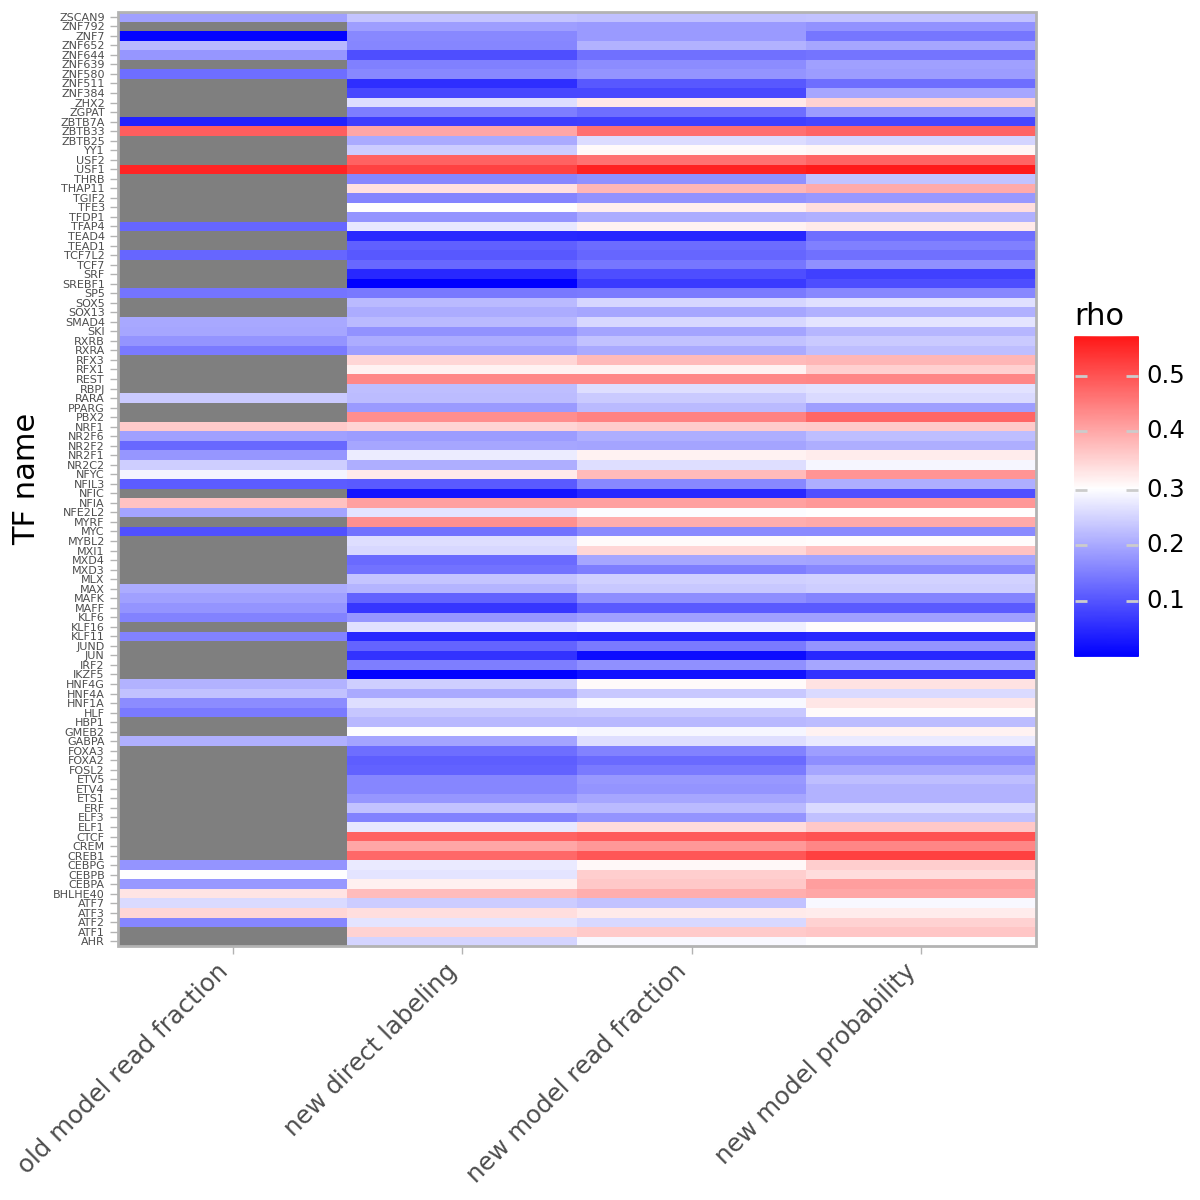

In [39]:
plt = (
    ggplot() + 
    geom_tile(df_spearman_corr_bound_combined, aes(x='read_frac_type', y='TF_name', fill='rho')) +
    scale_fill_gradient2(low='blue', mid='white', high='red', midpoint=0.3) +
    scale_x_discrete(expand=(0, 0)) +
    scale_y_discrete(expand=(0, 0)) + 
    theme_light() + labs(x='', y='TF name') +
    theme(figure_size=(6,6), axis_text_x=element_text(rotation=45, hjust=1), axis_text_y=element_text(size=4))
)
plt.show()



/net/home/tianyu/miniconda3/envs/ACCESS/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 20 rows containing missing values.


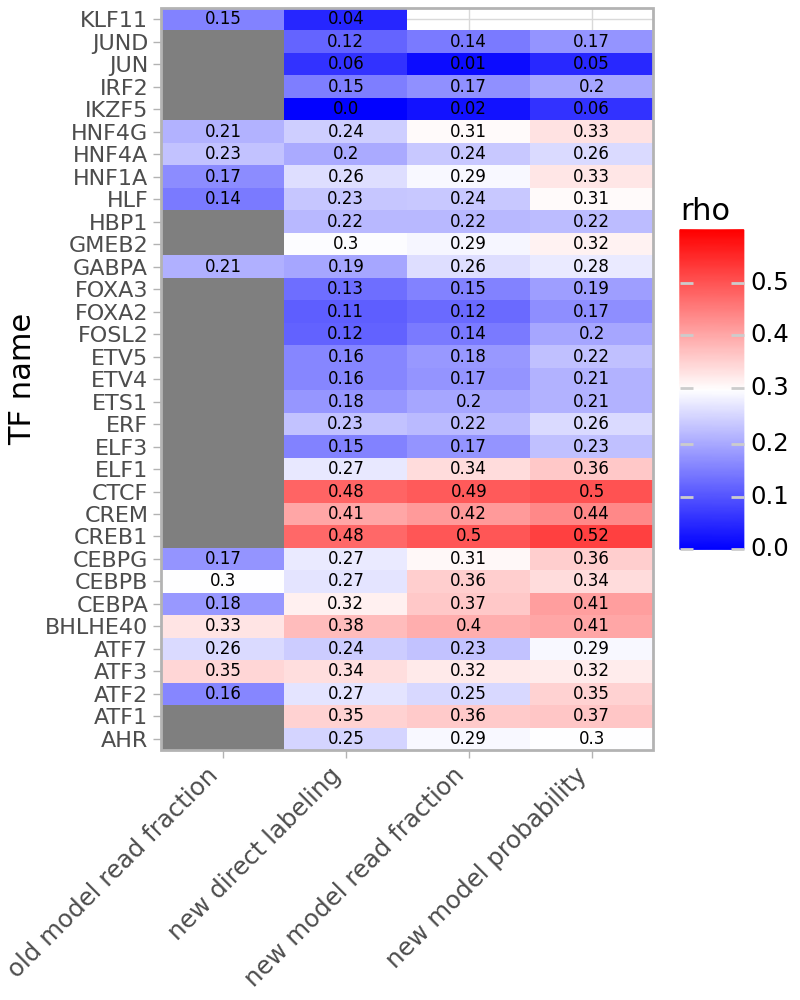

/net/home/tianyu/miniconda3/envs/ACCESS/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 14 rows containing missing values.


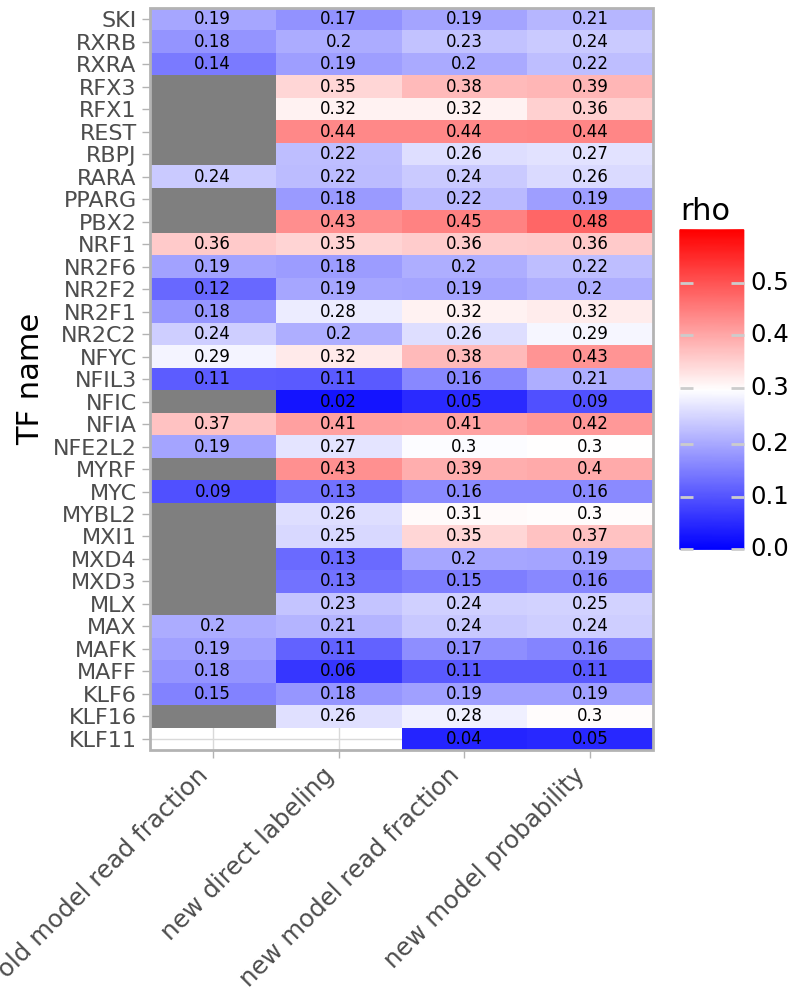

/net/home/tianyu/miniconda3/envs/ACCESS/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 21 rows containing missing values.


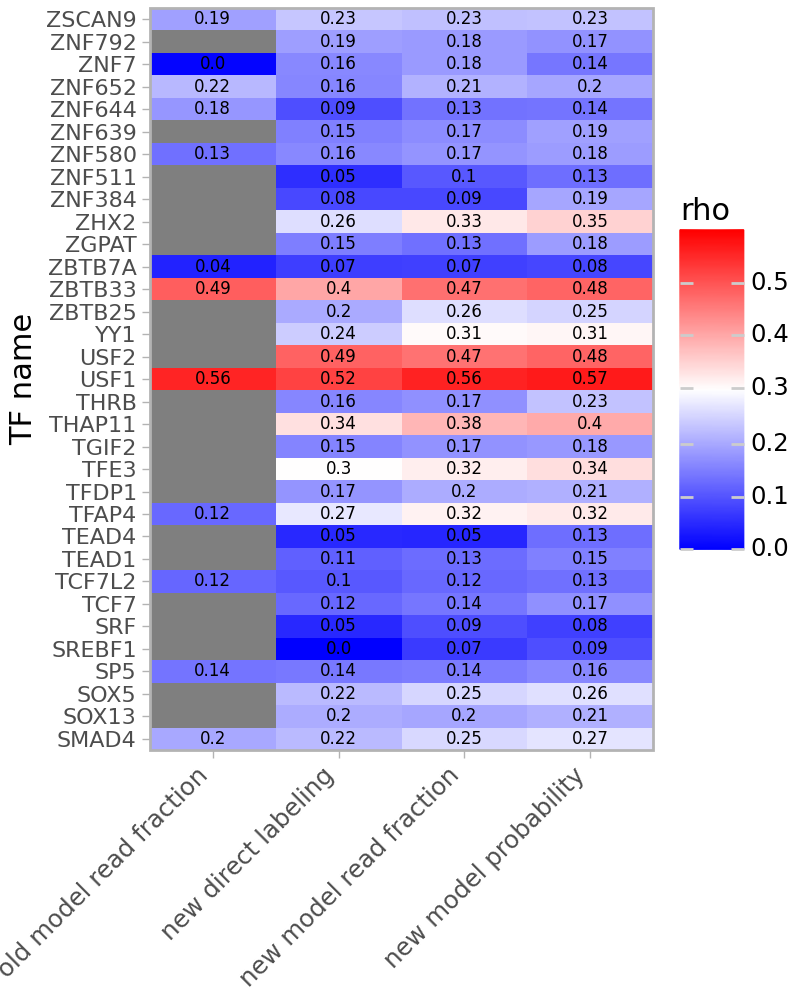

In [3]:
df_spearman_corr_bound_combined.sort_values(['TF_name', 'read_frac_type'], inplace=True)
df_spearman_corr_bound_combined['rho_rounded'] = df_spearman_corr_bound_combined['rho'].round(2)

# Split the data into three parts
n = len(df_spearman_corr_bound_combined) // 3
part1 = df_spearman_corr_bound_combined.iloc[:n]
part2 = df_spearman_corr_bound_combined.iloc[n:2*n]
part3 = df_spearman_corr_bound_combined.iloc[2*n:]

# Create the first part plot
plt_part1 = (
    ggplot(part1) +
    geom_tile(aes(x='read_frac_type', y='TF_name', fill='rho')) +
    geom_text(aes(x='read_frac_type', y='TF_name', label='rho_rounded'), size=6) +
    scale_fill_gradient2(low='blue', mid='white', high='red', midpoint=0.3, limits=(0, 0.6)) +
    scale_x_discrete(expand=(0, 0)) +
    scale_y_discrete(expand=(0, 0)) +
    theme_light() +
    labs(x='', y='TF name') +
    theme(
        figure_size=(4, 5),
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_text_y=element_text(size=8)
    )
)
plt_part1.show()

# Create the second part plot
plt_part2 = (
    ggplot(part2) +
    geom_tile(aes(x='read_frac_type', y='TF_name', fill='rho')) +
    geom_text(aes(x='read_frac_type', y='TF_name', label='rho_rounded'), size=6) +
    scale_fill_gradient2(low='blue', mid='white', high='red', midpoint=0.3, limits=(0, 0.6)) +
    scale_x_discrete(expand=(0, 0)) +
    scale_y_discrete(expand=(0, 0)) +
    theme_light() +
    labs(x='', y='TF name') +
    theme(
        figure_size=(4, 5),
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_text_y=element_text(size=8)
    )
)
plt_part2.show()    

# Create the third part plot
plt_part3 = (
    ggplot(part3) +
    geom_tile(aes(x='read_frac_type', y='TF_name', fill='rho')) +
    geom_text(aes(x='read_frac_type', y='TF_name', label='rho_rounded'), size=6) +
    scale_fill_gradient2(low='blue', mid='white', high='red', midpoint=0.3, limits=(0, 0.6)) +
    scale_x_discrete(expand=(0, 0)) +
    scale_y_discrete(expand=(0, 0)) +
    theme_light() +
    labs(x='', y='TF name') +
    theme(
        figure_size=(4, 5),
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_text_y=element_text(size=8)
    )
)
plt_part3.show()



In [ ]:

# df_spearman_corr_bound_wide.rename(columns={'defined': 'new direct labeling', 'predicted': 'new model read fraction', 'predicted_prob': 'new model probability'}, inplace=True)

read_frac_type,cell_type,TF_name,motif_str,defined,predicted,predicted_prob
0,HepG2,AHR,ENCSR412ZDC_GCTGTCCRYGGTGCTGAA,0.250432,0.291389,0.299481
1,HepG2,ATF1,ENCSR253OON_RTGACGTMANN,0.353046,0.362794,0.367633
2,HepG2,ATF2,ENCSR047BUZ_DDNGATGACGTCAT,0.268300,0.253554,0.352238
3,HepG2,ATF3,ENCSR000BKE_GGTSACGTGRB,0.339855,0.323595,0.322882
4,HepG2,ATF7,ENCSR545FXC_DVVATGACGTCATCH,0.240241,0.227462,0.292754
...,...,...,...,...,...,...
93,HepG2,ZNF644,ENCSR578CXC_TGGACTTTGRAC,0.090951,0.132969,0.136494
94,HepG2,ZNF652,ENCSR502GAX_TTAACCCTTTVNBBSCY,0.158349,0.209966,0.195555
95,HepG2,ZNF7,ENCSR553QMC_CYTTGYCARCWCTTR,0.159229,0.180557,0.138099
96,HepG2,ZNF792,ENCSR396SOH_GGCGCTGTCCRYGGTGCTGAA,0.186274,0.181833,0.171635


### compare improvement of spearman rho for model pronability from direct labeling
- here, direct labeling rho is from test-set motifs
- the direct labeling rho in the motif stats file is from feature identification motifs (chr1)

In [16]:
df_spearman_corr = pd.read_csv('/net/bgm/sherwood/factorbook_data/UltimaGen/evaluation_3stateModel_v2/HepG2_100/summary/spearman_corr.csv')
df_spearman_corr_bound = df_spearman_corr.loc[df_spearman_corr['read_type'] == 'bound'].copy()
df_spearman_corr_bound_wide = df_spearman_corr_bound.pivot(index=['cell_type', 'TF_name', 'motif_str'], columns='read_frac_type', values='rho').reset_index()
df_spearman_corr_bound_wide = df_spearman_corr_bound_wide.rename_axis(None, axis=1)
df_spearman_corr_bound_wide.rename(columns={'predicted': 'model read fraction'}, inplace=True)

df_stats = pd.read_csv('/net/bgm/sherwood/factorbook_data/UltimaGen/stats/TF_summary.features_filtered_HepG2_modeled.csv')
df_compare = df_stats[['cell_type', 'TF', 'motif', 'rho', 'model_rho']].copy()
df_compare.rename(columns={'rho': 'direct labeling', 'model_rho': 'model probability', 'TF': 'TF_name', 'motif': 'motif_str'}, inplace=True)
df_compare = df_compare.merge(df_spearman_corr_bound_wide[['cell_type', 'TF_name', 'motif_str', 'model read fraction']], on=['cell_type', 'TF_name', 'motif_str'], how='left')

df_compare['Probability'] = df_compare.apply(lambda row: (row['model probability'] - row['direct labeling'])/row['direct labeling'], axis=1)
df_compare['Read fraction'] = df_compare.apply(lambda row: (row['model read fraction'] - row['direct labeling'])/row['direct labeling'], axis=1)
df_compare = df_compare.melt(id_vars=['cell_type', 'TF_name', 'motif_str'], value_vars=['Probability', 'Read fraction'], var_name='model_output', value_name='delta_rho_frac')
df_compare

,cell_type,TF_name,motif_str,model_output,delta_rho_frac
0,HepG2,AHR,ENCSR412ZDC_GCTGTCCRYGGTGCTGAA,Probability,0.348063
1,HepG2,ATF1,ENCSR253OON_RTGACGTMANN,Probability,0.044374
2,HepG2,ATF2,ENCSR047BUZ_DDNGATGACGTCAT,Probability,1.441791
3,HepG2,ATF3,ENCSR000BKE_GGTSACGTGRB,Probability,-0.210454
4,HepG2,ATF7,ENCSR545FXC_DVVATGACGTCATCH,Probability,0.242510
...,...,...,...,...,...
123,HepG2,YY1,ENCSR000BNT_GCCGCCATSTTGGNN,Read fraction,0.122393
124,HepG2,ZBTB25,ENCSR485OYR_GCTGTCCRYGGTGCTGA,Read fraction,0.711300
125,HepG2,ZBTB33,ENCSR000BNA_BTCTCGCGAGABYTS,Read fraction,0.047673
126,HepG2,ZHX2,ENCSR407BEZ_GCCCNBANYCAAGATGGCGGC,Read fraction,0.701587


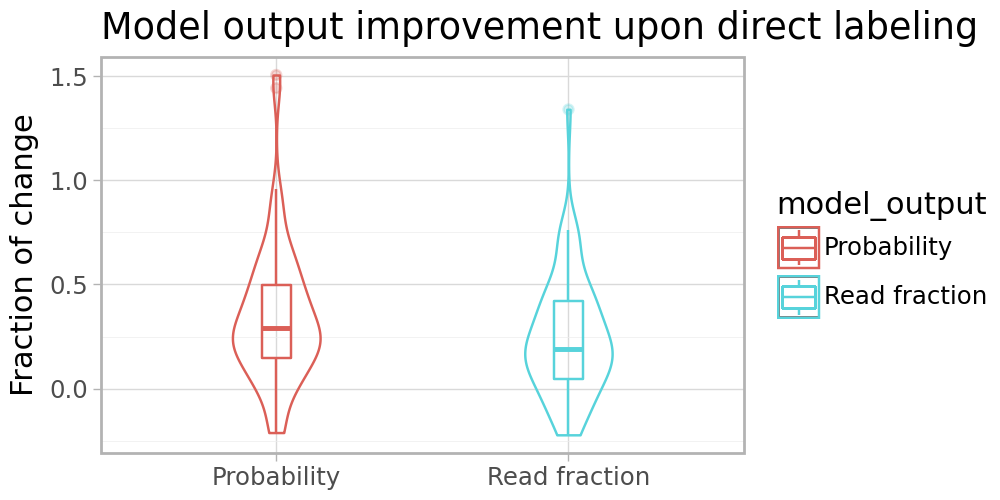

In [34]:
plt = (
    ggplot(df_compare, aes(x='model_output', y='delta_rho_frac', color='model_output')) + 
    geom_boxplot(fill=None, width=0.1, outlier_alpha=0.25) +
    geom_violin(fill=None, width=0.3) +
    theme_light() + labs(x='', y='Fraction of change', title='Model output improvement upon direct labeling') + 
    theme(figure_size=(5, 2.5), plot_title=element_text(ha='left'))
)
plt.show()

In [20]:
df_spearman_corr_bound_wide = df_spearman_corr_bound_wide.rename_axis(None, axis=1)
df_spearman_corr_bound_wide_filtered = df_spearman_corr_bound_wide.loc[df_spearman_corr_bound_wide['new model probability'] > 0.2].copy()
df_spearman_corr_bound_wide_filtered['Model probability'] = df_spearman_corr_bound_wide_filtered.apply(lambda row: (row['new model probability'] - row['new direct labeling'])/row['new direct labeling'], axis=1)
df_spearman_corr_bound_wide_filtered['Model read fraction'] = df_spearman_corr_bound_wide_filtered.apply(lambda row: (row['new model read fraction'] - row['new direct labeling'])/row['new direct labeling'], axis=1)
df_spearman_corr_bound_improvement_frac = df_spearman_corr_bound_wide_filtered.melt(id_vars=['cell_type', 'TF_name', 'motif_str'], value_vars=['Model probability', 'Model read fraction'], var_name='model_output', value_name='improvement_frac')
df_spearman_corr_bound_improvement_frac

,cell_type,TF_name,motif_str,model_output,improvement_frac
0,HepG2,AHR,ENCSR412ZDC_GCTGTCCRYGGTGCTGAA,Model probability,0.195858
1,HepG2,ATF1,ENCSR253OON_RTGACGTMANN,Model probability,0.041316
2,HepG2,ATF2,ENCSR047BUZ_DDNGATGACGTCAT,Model probability,0.312854
3,HepG2,ATF3,ENCSR000BKE_GGTSACGTGRB,Model probability,-0.049943
4,HepG2,ATF7,ENCSR545FXC_DVVATGACGTCATCH,Model probability,0.218584
...,...,...,...,...,...
123,HepG2,YY1,ENCSR000BNT_GCCGCCATSTTGGNN,Model read fraction,0.274211
124,HepG2,ZBTB25,ENCSR485OYR_GCTGTCCRYGGTGCTGA,Model read fraction,0.304455
125,HepG2,ZBTB33,ENCSR000BNA_BTCTCGCGAGABYTS,Model read fraction,0.154826
126,HepG2,ZHX2,ENCSR407BEZ_GCCCNBANYCAAGATGGCGGC,Model read fraction,0.253112


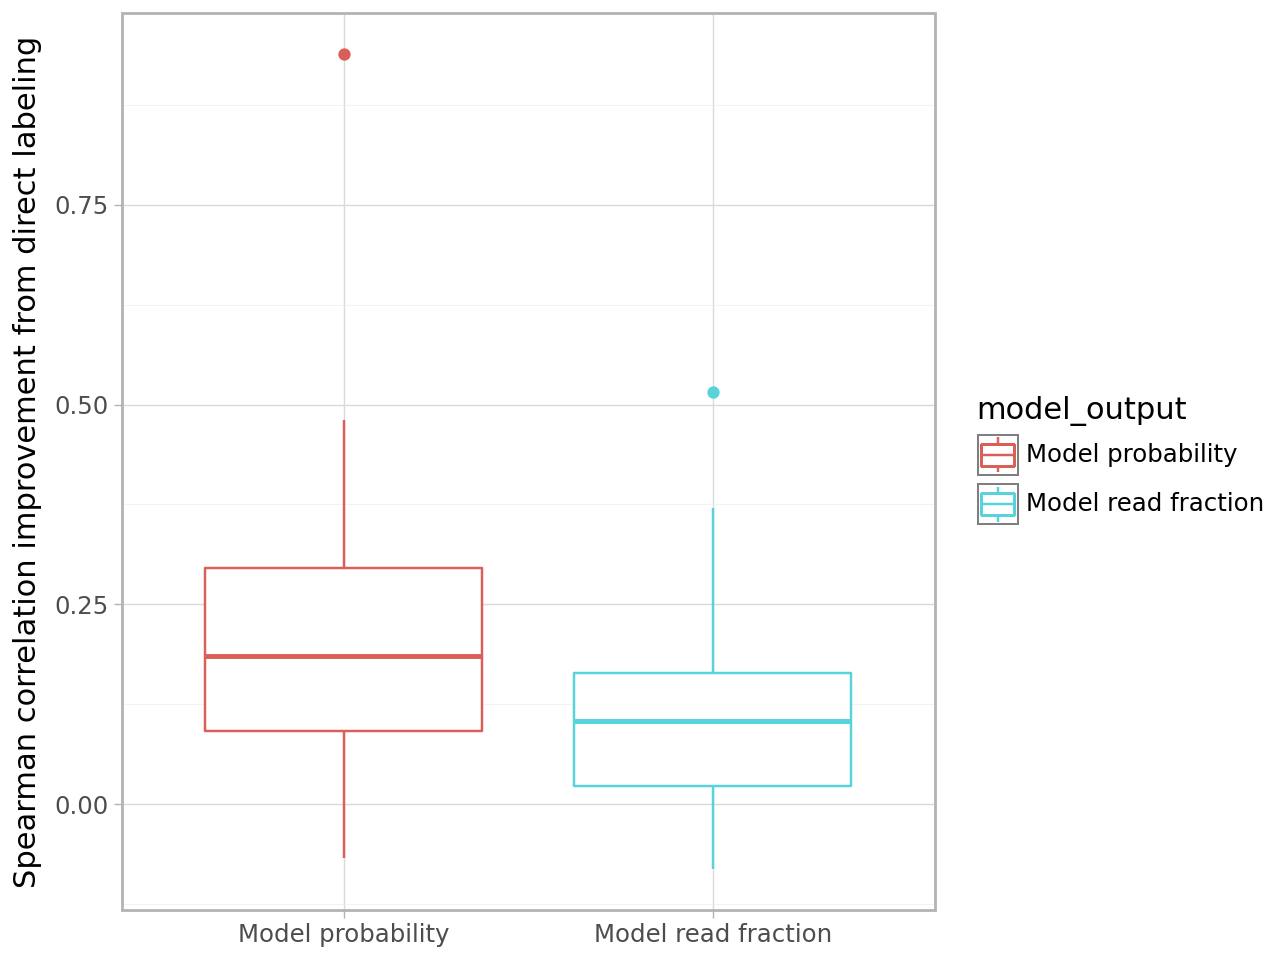

In [24]:
plt = (
    ggplot() + 
    geom_boxplot(df_spearman_corr_bound_improvement_frac, aes(x='model_output', y='improvement_frac', color='model_output')) +
    theme_light() + labs(x='', y='Spearman correlation improvement from direct labeling')
)
plt.show()